## Lab 1 - Regular expressions

In [1]:
import os
import regex
import morfeusz2

from matplotlib import pyplot as plt

In [2]:
bills_dir = '../bills/'
bills_files = os.listdir(bills_dir)

### Tasks 1 & 2

Types of units from: https://pl.wikipedia.org/wiki/Jednostka_redakcyjna_tekstu_prawnego  
Skipping last two on purpose, didn't see any occurence in bills which would need to be counted (they also have vastly different construction).  

Each unit name is followed by a number with possible letter (e.g. `art. 3a`), except from `lit.` which requires a letter and maybe closing parenthesis  
(e.g. in file 2001_1444.txt: `pkt 8 lit. d otrzymuje brzmienie` and `pkt 4 lit. a) otrzymuje brzmienie`).  
Also, sometimes there was no space between unit name and its number/letter - hence the `\s?` in the list of units.  
(e.g. in file 2001_475.txt: `skreśla się art.42`).

In [3]:
units_condition = r"(?:{})".format("|".join([r"art\.\s?\d+[a-z]?", r"ust\.\s?\d+[a-z]?", r"pkt\s?\d+[a-z]?",
                                             r"lit\.\s?(?:[a-z]\)?|[a-z]\)? i [a-z]\)?)", r"§\s?\d+[a-z]?"]))

changes_by_year = {int(file[:4]): {'added': 0, 'modified': 0, 'removed': 0} for file in bills_files}
sum_modified, sum_added, sum_removed = 0, 0, 0

for file_path in [bills_dir + filename for filename in  bills_files]:
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()

    modifications = regex.findall(r"{} otrzymuje brzmienie".format(units_condition), text, flags=regex.IGNORECASE)
    additions = regex.findall(r"dodaje się {}".format(units_condition), text, flags=regex.IGNORECASE)
    deletions = regex.findall(r"skreśla się {}".format(units_condition), text, flags=regex.IGNORECASE)

    changes_by_year[int(file_path[9:13])]['modified'] += len(modifications)
    changes_by_year[int(file_path[9:13])]['added'] += len(additions)
    changes_by_year[int(file_path[9:13])]['removed'] += len(deletions)

    sum_modified += len(modifications)
    sum_added += len(additions)
    sum_removed += len(deletions)
        
    # print(file_path, len(modifications), len(additions), len(deletions)) # to see values for each file

print(changes_by_year)

{1993: {'added': 32, 'modified': 56, 'removed': 5}, 1994: {'added': 99, 'modified': 156, 'removed': 34}, 1995: {'added': 327, 'modified': 337, 'removed': 83}, 1996: {'added': 491, 'modified': 821, 'removed': 211}, 1997: {'added': 642, 'modified': 1000, 'removed': 278}, 1998: {'added': 219, 'modified': 277, 'removed': 78}, 1999: {'added': 159, 'modified': 154, 'removed': 55}, 2000: {'added': 747, 'modified': 1363, 'removed': 316}, 2001: {'added': 1069, 'modified': 1226, 'removed': 259}, 2002: {'added': 87, 'modified': 108, 'removed': 1}, 2003: {'added': 988, 'modified': 1186, 'removed': 4}, 2004: {'added': 944, 'modified': 1135, 'removed': 1}}


Above we can see all the changes grouped by year and change type.

### Task 3

Plotting the percentage of each change type every year.

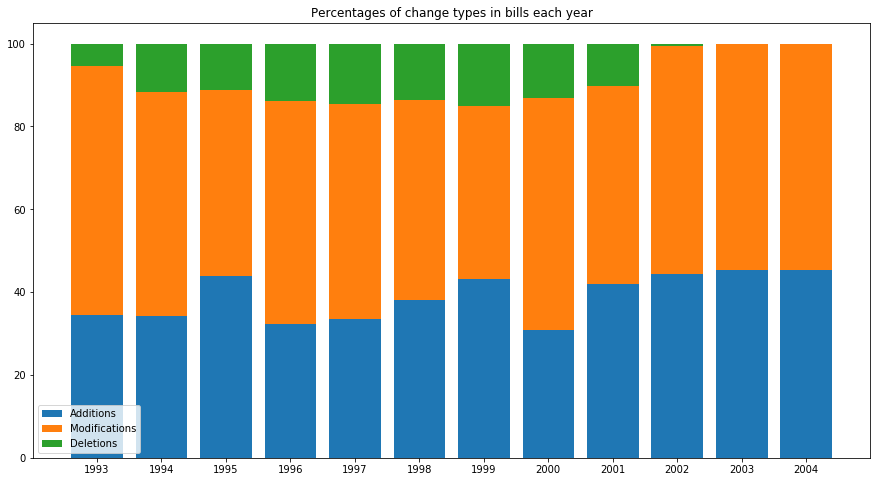

In [4]:
years = list(changes_by_year.keys())
y_added = [changes_by_year[year]['added'] / sum(changes_by_year[year].values()) * 100 for year in years]
y_modified = [changes_by_year[year]['modified'] / sum(changes_by_year[year].values()) * 100 for year in years]
y_removed = [changes_by_year[year]['removed'] / sum(changes_by_year[year].values()) * 100 for year in years]

plt.figure(figsize=(15,8))

plt.bar(years, y_added, label="Additions")
plt.bar(years, y_modified, label="Modifications", bottom=y_added)
plt.bar(years, y_removed, label="Deletions", bottom=[sum(x) for x in zip(y_added, y_modified)])
plt.xticks(years)
plt.legend()
plt.title("Percentages of change types in bills each year")
plt.show()

From the figure we can see that deletions represented ~10-15% of all the changes each year until the year 2002 where it becomes barely visible.  
Aside from that, sudden increase in additions in 1995 and increase of modifications in 2000 are the only ones that break the trend - additions ~40%, deletions 10-15% and modifications as the rest.

### Tasks 4-7

All inflectional forms of the word `ustawa` are generated using morfeusz library. Then all the options (without the last one which is an abbreviation) are grouped into an alternative and surrounded by `\b` word bound symbol - this way something like `USTAWiać` will not match the expression.

In [5]:
word_to_count = "ustawa"
suffix1 = " z dnia"
suffix2 = " o zmianie"

count_raw, count_with_suffix1, count_without_suffix1, count_without_suffix2 = 0, 0, 0, 0

morf = morfeusz2.Morfeusz()
word_reg_expr = r"\b(?:{})\b".format("|".join(["{}".format(x[0]) for x in morf.generate(word_to_count)[:-1]]))

for file_path in [bills_dir + filename for filename in  bills_files]:
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
   
    count_raw += len(regex.findall(word_reg_expr, text, regex.IGNORECASE))
    count_with_suffix1 += len(regex.findall("{}(?={})".format(word_reg_expr, suffix1), text, regex.IGNORECASE))
    count_without_suffix1 += len(regex.findall("{}(?!{})".format(word_reg_expr, suffix1), text, regex.IGNORECASE))
    count_without_suffix2 += len(regex.findall("{}(?!{})".format(word_reg_expr, suffix2), text, regex.IGNORECASE))

In [6]:
print("Occurrences of word 'ustawa' ", count_raw)
print("Occurrences of word 'ustawa' followed by ' z dnia': ", count_with_suffix1)
print("Occurrences of word 'ustawa' not followed by ' z dnia': ", count_without_suffix1)
print("{} + {} = {} == {} - {}".format(count_with_suffix1, count_without_suffix1, 
                                       count_with_suffix1 + count_without_suffix1, count_raw, 
                                       "Values match" if count_with_suffix1 + count_without_suffix1 == count_raw else "???"))
print("Occurrences of word 'ustawa' not followed by ' o zmianie': ", count_without_suffix2)



Occurrences of word 'ustawa'  25092
Occurrences of word 'ustawa' followed by ' z dnia':  6979
Occurrences of word 'ustawa' not followed by ' z dnia':  18113
6979 + 18113 = 25092 == 25092 - Values match
Occurrences of word 'ustawa' not followed by ' o zmianie':  25064


### Task 8

Plotting the result of prior code.

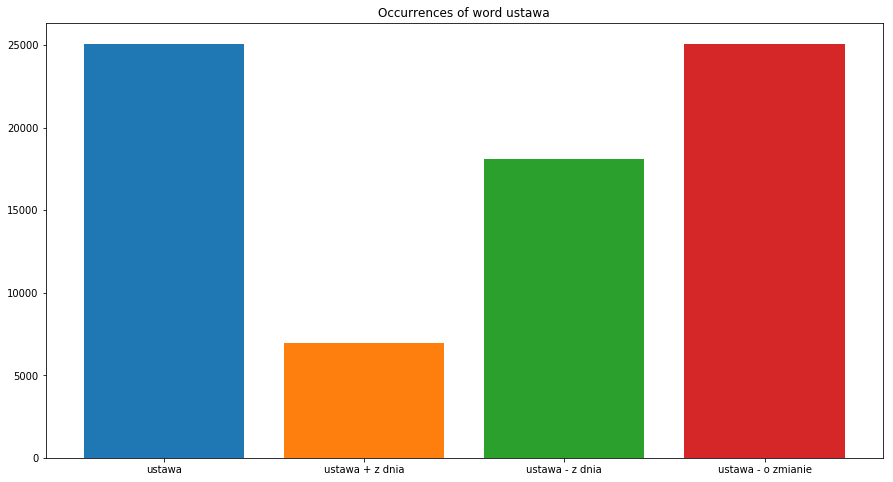

In [7]:
plt.figure(figsize=(15,8))
plt.bar("ustawa", count_raw)
plt.bar("ustawa + z dnia", count_with_suffix1)
plt.bar("ustawa - z dnia", count_without_suffix1)
plt.bar("ustawa - o zmianie", count_without_suffix2)
plt.title("Occurrences of word ustawa")
plt.show()

As we can see the first and forth bar are nearly identical which means that the word `ustawa` was barely ever followed by ` o zmianie`.  
Also, we can deduce that the word `ustawa` was followed by `z dnia` roughly 25% of the time.